<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/lab_solutions/Labs/Lab06_GPS_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 6: GPS and solving nonlinear equations, SOLUTIONS

We'll look at [global navigation satellite system (GNSS)](https://en.wikipedia.org/wiki/Satellite_navigation) (which includes GPS...)

### Learning Objectives
1. Hands on experience using Newton's method to solve a nonlinear system of equations
2. Learn a little bit about how GPS works
3. Having fun

### Deliverables
- Turn in a PDF to Canvas that either
  - shows a map location with a good estimate (hint: all locations are within Boulder, Broomfield and Weld counties), or
  - if you didn't get it working, just turn in a PDF showing your code

Copyright 2025, Department of Applied Mathematics, University of Colorado Boulder. Released under the BSD 3-Clause License

Written by Stephen Becker

This builds heavily off of [gnss_lib_py](https://gnss-lib-py.readthedocs.io/en/latest/index.html), copyright 2021 Stanford-NavLab, released under the MIT License.  Thank you for making such a useful too!

In [1]:
import geopy, os, glob
from geopy.geocoders import Nominatim
import numpy as np
import sys
print(sys.version)
%pip install gnss-lib-py --quiet --progress-bar off
import gnss_lib_py as glp  # requires Python: >=3.9, <3.13
geolocator = Nominatim(user_agent="APPM 4600 class")
from gnss_lib_py.navdata.operations import loop_time
from gnss_lib_py.utils.coordinates import ecef_to_geodetic
from gnss_lib_py.navdata.navdata import NavData
from gnss_lib_py.utils import constants as consts

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Warmup: implement Newton's method
Below is a call signature for `my_Newton` which you will use later. So implement it, and then check on the provided test function that it's working.

Note: in class we've always had # of equations = # of parameters so far. If we have more equations than parameters, then instead of solving $J^{-1} F(\vec{x})$ (via, e.g., `np.linalg.solve`), you can get a least norm solution via $J^\dagger F(\vec{x})$ where $J^\dagger = (J^\top J)^{-1} J^\top$ is the Moore-Penrose pseudoinverse. In numpy, you can get this solution `np.linalg.lstsq`.  This is equivalent to the "Gauss Newton" method we'll talk about later.

I bring this up because when we use Newton's method in GNSS, if we have exactly 4 satellites, then we have the same number of equations as unknowns. But we often have data from more than 4 satellites, and it's a shame to waste that information, so we'll try to use it.  For nice GNSS implementations, you'd actually *weight* each equation by your estimate of the error, since you might have better data from some satellites.

**Solution**

In [2]:
def my_Newton(F, J, x, tol = 1e-7, max_count = 20, errFcn = None ):
  x = np.asarray(x, dtype = 'float64')
  for iter in range(max_count):
    resid = F( x )
    if errFcn is not None:
      print(f'Iteration {iter+1:2d}, norm of residual is {np.linalg.norm(resid):.2e}, error is {errFcn(x):.2e}')
    else:
      print(f'Iteration {iter+1:2d}, norm of residual is {np.linalg.norm(resid):.2e}')
    Jx = J( x )
    if Jx.shape[0] == Jx.shape[1]:
        # we have n equations and n unknowns (i.e., it's square)
        step = np.linalg.solve( Jx, resid )
    else:
        # use a pseudoinverse, which is the same as the last norm solution
        step  = np.linalg.lstsq( Jx, resid )[0]
        # step  = np.linalg.pinv( Jx ) @ resid # another way
    x -= step
    if np.linalg.norm(step) < tol:
        print(f'Reached tolerance, stopping')
        break
  return x

# Check that it works on a simple problem with a known answer
def F( xy ):
    """ xy = [x,y], and we solve  x + e^y = 2, 2x + 4e^y = 8
    and you can work out that y = ln(2) and x=0 are the solutions """
    return np.array([xy[0] + np.exp(xy[1]) - 2, 2*xy[0] + 4*np.exp(xy[1]) - 8])
def J( xy ):
    """ Jacobian of the F defined above """
    return np.array([[1, np.exp(xy[1])], [2, 4*np.exp(xy[1])]])

trueSoln = np.array( [0,np.log(2)] )
errFcn   = lambda x : np.linalg.norm( x - trueSoln )
x = my_Newton( F, J, np.array([0,0]), errFcn = errFcn )


Iteration  1, norm of residual is 4.12e+00, error is 6.93e-01
Iteration  2, norm of residual is 2.96e+00, error is 3.07e-01
Iteration  3, norm of residual is 3.59e-01, error is 4.26e-02
Iteration  4, norm of residual is 7.38e-03, error is 8.95e-04
Iteration  5, norm of residual is 3.30e-06, error is 4.00e-07
Iteration  6, norm of residual is 6.61e-13, error is 8.02e-14
Reached tolerance, stopping


## Step 2: get data

Your instructor used the [Google GNSSLogger Android App](https://play.google.com/store/apps/details?id=com.google.android.apps.location.gps.gnsslogger&pcampaignid=web_share) to record GNSS/GPS data on his phone, following the [gnss_lib_py suggestion](https://gnss-lib-py.readthedocs.io/en/latest/tutorials/parsers/tutorials_android_notebook.html).  We have some raw data files with the satellite measurements from him driving throughout the Boulder/Denver metro area in September 2025.

Your task is to pinpoint the exact locations!

In [ ]:
# Download all data
for alph in ['A','B','C','D']:
    os.system(f'wget -q https://raw.githubusercontent.com/cu-applied-math/appm-4600-numerics/refs/heads/main/Labs/Data/gnss_log_{alph}.txt')
for i in range(ord('E'),ord('A')+26, 2):
    alph = chr(i) + chr(i+1)
    os.system(f'wget -q https://raw.githubusercontent.com/cu-applied-math/appm-4600-numerics/refs/heads/main/Labs/Data/gnss_log_{alph}.txt')

In [ ]:
# And you'll work with a specific file (it might not be the same as your friends')
letter = 'C'  # change this to the first letter of your last name.
# Edit -- not all log files work.
# Good: C, EF, GH, IJ.
# Bad: A, B, D, KL, MN, OP, QR, ST, UV, WX, YZ
logfile = glob.glob(f'gnss_log_{letter.upper()}*.txt')[0]
logfile

'gnss_log_C.txt'

Load the raw data into a nice format for `gnss_lib_py`, then download the satellite ("sv") locations and add that to our data object. We'll then restrict to just the USA "gps" constellation (but you can also use Europe's "galileo" constellation or Russian or Chinese

In [ ]:
raw_data = glp.AndroidRawGnss(input_path=logfile)
raw_data = raw_data.where("gnss_id",("gps"))
# raw_data = raw_data.where("gnss_id",("galileo"))
full_states = glp.add_sv_states(raw_data, source="precise", verbose=False, download_directory='./')
full_states["corr_pr_m"] = full_states["raw_pr_m"] \
                         + full_states['b_sv_m']
# full_states = full_states.where("gnss_id",("gps")) # already did this to raw data

## Step 3: solve for the position

Your job is to implement the following function
```python
def my_GNSS_Newton(rx_est_m, pos_sv_m, corr_pr_m,  tol = 1e-7, max_count = 20 ):
    """Newton solver for GNSS measurements.

    Acronyms: "rx" is for receiver (where you were when you took the measurements)
      "sv" is for satellite
      "pr" or "Pseudorange" is speed-of-light x time (so it should be a distance)
        since elapsed time is measured by the satellites

    Parameters
    ----------
    rx_est_m : np.ndarray
        Estimated receiver position in ECEF frame in meters and the
        estimated receiver clock bias also in meters in an
        array with shape (4 x 1) and the following order:
        x_rx_m, y_rx_m, z_rx_m, b_rx_m.
    pos_sv_m : np.ndarray
        Satellite ECEF positions as an array of shape [# svs x 3] where
        the columns contain in order x_sv_m, y_sv_m, and z_sv_m.
    corr_pr_m : np.ndarray
        Corrected pseudoranges for all satellites with shape of
        [# svs x 1]

    Returns
    -------
    rx_est_m : np.ndarray
        Estimated receiver position in ECEF frame in meters and the
        estimated receiver clock bias also in meters in an
        array with shape (4 x 1) and the following order:
        x_rx_m, y_rx_m, z_rx_m, b_rx_m.
    """
```
which will be called from within the `my_solve` function (**don't modify** this function, as it does lots of bookkeeping and GNSS stuff)


In [ ]:
def my_solve(measurements,  tol = 1e-7, max_count = 20,
              sv_rx_time=False, delta_t_decimals=-2, solver=None, x0 = None):
    """Runs my_GNSS_Newton across each timestep and adds a new
    row for the receiver's position and clock bias.

    Modified/simplified by Stephen Becker freom the original "solve_wls" at
    https://github.com/Stanford-NavLab/gnss_lib_py/blob/main/gnss_lib_py/algorithms/snapshot.py

    Parameters
    ----------
    measurements : gnss_lib_py.navdata.navdata.NavData
        Instance of the NavData class which must include at least
        ``gps_millis``, ``x_sv_m``, ``y_sv_m``, and ``z_sv_m``.

    Returns
    -------
    state_estimate : gnss_lib_py.navdata.navdata.NavData
        Estimated receiver position in ECEF frame in meters and the
        estimated receiver clock bias also in meters as an instance of
        the NavData class with shape (4 x # unique timesteps) and
        the following rows: gps_millis, x_rx_wls_m, y_rx_wls_m,
        z_rx_wls_m, b_rx_wls_m, lat_rx_wls_deg, lon_rx_wls_deg,
        alt_rx_wls_m.

    """
    # check that all necessary rows exist
    measurements.in_rows(["x_sv_m","y_sv_m","z_sv_m","gps_millis"])

    states = []
    runtime_error_idxs = {}

    position = np.zeros((4,1))
    if x0 is not None:
        position[:3] = x0
    for timestamp, _, measurement_subset in loop_time(measurements,"gps_millis",
                                                      delta_t_decimals=delta_t_decimals):
        pos_sv_m = measurement_subset[["x_sv_m","y_sv_m","z_sv_m"]].T
        pos_sv_m = np.atleast_2d(pos_sv_m)
        corr_pr_m = measurement_subset["corr_pr_m"].reshape(-1,1)
        # remove NaN indexes
        not_nan_indexes = ~np.isnan(pos_sv_m).any(axis=1) & ~np.isnan(corr_pr_m).any(axis=1)
        pos_sv_m = pos_sv_m[not_nan_indexes]
        corr_pr_m = corr_pr_m[not_nan_indexes]

        # Call the root-finding "solver" that you'll implement yourself
        position = solver(position, pos_sv_m, corr_pr_m, tol, max_count)
        states.append([timestamp] + np.squeeze(position).tolist())
        # For APPM 4600, just get one location
        break

    states = np.array(states)
    state_estimate = NavData()
    state_estimate["gps_millis"] = states[:,0]
    state_estimate["x_rx_wls_m"] = states[:,1]
    state_estimate["y_rx_wls_m"] = states[:,2]
    state_estimate["z_rx_wls_m"] = states[:,3]
    state_estimate["b_rx_wls_m"] = states[:,4]
    lat,lon,alt = ecef_to_geodetic(state_estimate[["x_rx_wls_m","y_rx_wls_m",
                                   "z_rx_wls_m"]].reshape(3,-1))
    state_estimate["lat_rx_wls_deg"] = lat
    state_estimate["lon_rx_wls_deg"] = lon
    state_estimate["alt_rx_wls_m"] = alt
    return state_estimate

### Do the "trilateration"
The inputs are:
- `rx_est_m`, initial guess for the space and time of the receiver (e.g., my smartphone). This is what we want to update!  It's of size $4\times 1$. In the math notation below, this is the vector $(\vec{x}, ct_b)$ where $t_b$ is the time bias and $c$ is the speed of light. So the 4th component is really a pseudorange, as described below. Note:
"**rx**" stands for **receiver**
- `pos_sv_m`, the position of the satellites. There should be at least 4 satellites, but often more, like 7.  This will have 3 columns (for the 3D spatial locations of each satellite).  "**sv**" stands for **satellites** (really, "space vehicle")
- `corr_pr_m`, the "**pseudorange**" for each satellite. That is, given our estimate $\Delta t$ of how long it take the message from the satellite to reach us, we convert this to a distance/range using "distance = rate x time" i.e., $c \Delta t$ where $c$ is the speed of light.

Let's recap the math:

(We're doing "trilateration")

Say our receiver is at 3D location $\vec{x}$ and each satellite $i$ is at position $\vec{s}_i$.  We know when a satellite sent its signal, and when we received it, so we know the travel time $\Delta t$, and by multiplying this by the speed of light $c$, we get the pseudorange $r = c \Delta t$.  So for at least 3 satellites, we want to solve the equations
$$\begin{align}
\|\vec{x} - \vec{s}_1 \|_2 &= r_1 \\
\|\vec{x} - \vec{s}_2 \|_2 &= r_2 \\
\|\vec{x} - \vec{s}_3 \|_2 &= r_3
\end{align}
$$
for the unknown $\vec{x}\in\mathbb{R}^3$.

However, we don't know the travel time exactly enough, because our receiver's clock isn't accurate enough. So we may have an unknown offset, $t_b$, referred to the bias. Or converting this to a pseudorange, we can refer to it as $r_b = c t_b$. This is our 4th unknown.  Thus we now solve for 4 unknowns, using at least 4 satellites:
$$\begin{align}
\|\vec{x} - \vec{s}_1 \|_2 &= r_1 + r_b \\
\|\vec{x} - \vec{s}_2 \|_2 &= r_2 + r_b\\
\|\vec{x} - \vec{s}_3 \|_2 &= r_3 + r_b\\
\|\vec{x} - \vec{s}_4 \|_2 &= r_4 + r_b
\end{align}
$$
for the unknown $(\vec{x},r_b)\in\mathbb{R}^4$. We've just defind our "$F$" function that we've been using in class for root finding.

We can also square both sides of the equation if we want, since that makes finding derivatives easier (since $\|\vec{x}\|_2^2$ is differentiable everywhere whereas $\|\vec{x}\|_2$ isn't differentiable at $\vec{0}$). This makes it a little nicer in some ways, though now we've introduced an ambiguity in the pseudorange a bit but that's not a big deal. So our $F$ is:
$$\begin{align}
\|\vec{x} - \vec{s}_1 \|_2^2 - (r_b + r_1)^2 &= 0 \\
\|\vec{x} - \vec{s}_2 \|_2^2 - (r_b + r_2)^2 &= 0\\
\|\vec{x} - \vec{s}_3 \|_2^2 - (r_b + r_3)^2 &= 0\\
\|\vec{x} - \vec{s}_4 \|_2^2 - (r_b + r_4)^2 &= 0
\end{align}
$$

So now...
### Edit the code below!


**Solution**:


In [ ]:
def my_GNSS_Newton(rx_est_m, pos_sv_m, corr_pr_m,  tol = 1e-7, max_count = 20 ):
    """ See above for call signature  """
    rx_est_m = rx_est_m.copy() # shape (4,1), 3d of space and 1d of time (or time offset or "bias")

    # Store the SV position at the original receiver time.
    # This position will be modified by the time taken by the signal to
    # travel to the receiver.
    rx_time_pos_sv_m = pos_sv_m.copy() # number-of-satellites x 3 (their positions)
    num_svs = pos_sv_m.shape[0]
    if num_svs < 4: # Number of satellites.  SV = Satellite, RX = Receiver location
        raise RuntimeError("Need at least four satellites for WLS.")

    # If we want to make it invertible, we could restrict to the 1st 4 satellites...
    # num_svs = 4 #


    scaling = (1/consts.C)**2 # not necessary, but nice to have it in a reasonable range
    def F( x_and_ct ):
        """ x_and_ct is a vector if size 4, 1st 3 components are position, last one is c'time-bias', i.e., a pseudorange """
        x  = x_and_ct[:3]
        ct = x_and_ct[-1]  # speed-of-light x time, aka pseudorange
        out = np.empty( (num_svs,1) ) # number of satellites
        # Note: shape of (num_svs,) can lead to errors. Make it (num_svs,1)
        for sat in range(num_svs):
            out[sat] = np.linalg.norm( x.ravel() - pos_sv_m[sat].ravel() )**2/2 - (ct - corr_pr_m[sat])**2/2
        return scaling*out

    # and define Jacobian
    def J( x_and_ct ):
        x  = x_and_ct[:3]
        ct = x_and_ct[-1]  # speed-of-light x time, aka pseudorange
        out = np.empty( (num_svs,4) ) # number of satellites x number of variables
        for sat in range(num_svs):
            # Don't forget negative sign for the ct term!
            out[sat] = np.concatenate( (x.ravel() - pos_sv_m[sat].ravel(),  - (ct - corr_pr_m[sat])) )
        return scaling*out

    # Let's try our Newton method:
    rx_est_m = my_Newton( F, J, rx_est_m, max_count=max_count, tol=tol )
    return rx_est_m

In [ ]:
location = geolocator.geocode("White House") # in latitude, longitude, altitude
x0 = glp.geodetic_to_ecef( \
      np.array( [location.latitude, location.longitude, location.altitude] ).reshape(3,1) )
my_location_estimate = my_solve( full_states, solver=my_GNSS_Newton, x0 = x0, max_count=10 )

Iteration  1, norm of residual is 1.19e-03
Iteration  2, norm of residual is 1.00e-04
Iteration  3, norm of residual is 2.00e-07
Iteration  4, norm of residual is 3.09e-08
Iteration  5, norm of residual is 3.09e-08
Reached tolerance, stopping


and print out an estimate of the address (using [geopy](https://geopy.readthedocs.io/en/stable/) with the Nominatum Geocoder) and a map (using the [gnss_lib_py](https://gnss-lib-py.readthedocs.io/) tools).

If you get this working, I suggest running for `max_count=0`, then `max_count=1`, then `max_count=2`, etc., and plotting the map location every time. You can see how the location estimate gets refined. With `max_count=0`, it should just return the initial guess `x0` which was the White House in Washington D.C.  If you do `max_count=1`, what US State are you in?

In [ ]:
lat, lon = my_location_estimate[-3:-1,:]
latlon_string = f"{lat}, {lon}"
location = geolocator.reverse(latlon_string) # reverse encoding
print(location.address)

raw_fig = glp.plot_map(my_location_estimate)
raw_fig.show()

Ken Pratt Boulevard, Longmont, Boulder County, Colorado, 80503, United States


In [ ]:
my_location_estimate

     gps_millis  x_rx_wls_m  y_rx_wls_m    z_rx_wls_m  b_rx_wls_m  \
0  1.442274e+12         0.0  -61.161416 -6.292826e+06         0.0   

   lat_rx_wls_deg  lon_rx_wls_deg  alt_rx_wls_m  
0      -89.999447           -90.0 -63926.194606  

### Or if you prefer, solve an academic example
We can create the data ourselves so that we know the true answer. This let's you get some confidence in your method, and it also removes many complicating factors (uncertainty in measurements, coordinate systems, the fact that the satellites are moving, etc.)

Below I've set up a basic system (the numbers are not physical)

We'll start by assuming we know the exact times, then move on to assuming we don't

In [3]:
n = 3 # dimension of space
m = 3 # number of satellites, should be at least 3 for now

xTrue = np.array( [1,2,3] ) # true location of receiver

rng = np.random.default_rng(123)
S   = rng.standard_normal( (m,n) ) # locations of satellites, arbitrary for now
c   = 7.8 # speed of light
r   = np.linalg.norm( S - xTrue, axis=1 ) # true ranges
t   = r / c # travel times
pr  = c*t # measured pseudoranges
print('The measured data are the pseudorange "pr", one per satellite')
print('  and we also know the satellite locations, S')
print('  Goal: find your location "x"')
print(pr)

The measured data are the pseudorange "pr", one per satellite
  and we also know the satellite locations, S
  Goal: find your location "x"
[3.53471601 2.77236444 3.97538954]


**Solution**

In [8]:
# our variable is x
def F(x):
    out = np.empty(m)
    for sat in range(m):
        out[sat] = np.linalg.norm( x.ravel() - S[sat].ravel() )**2 - pr[sat]**2
    return out

def J(x):
    out = np.empty( (m,n) )
    for sat in range(m):
        out[sat] = 2*(x.ravel() - S[sat].ravel() )
    return out

errFcn = lambda x : np.linalg.norm(x - xTrue)
x = my_Newton( F, J, np.array([0,1,1]), max_count=10, errFcn = errFcn )
# Careful! if you have exactly 3 satellites, then there are 2 possible solutions
# so whether you find the "right" solution depends on your initial guess

Iteration  1, norm of residual is 1.81e+01, error is 2.45e+00
Iteration  2, norm of residual is 2.11e+02, error is 1.01e+01
Iteration  3, norm of residual is 5.24e+01, error is 4.63e+00
Iteration  4, norm of residual is 1.27e+01, error is 1.92e+00
Iteration  5, norm of residual is 2.83e+00, error is 6.44e-01
Iteration  6, norm of residual is 4.57e-01, error is 1.30e-01
Iteration  7, norm of residual is 2.60e-02, error is 7.90e-03
Iteration  8, norm of residual is 1.07e-04, error is 3.27e-05
Iteration  9, norm of residual is 1.85e-09, error is 5.65e-10
Reached tolerance, stopping


Now suppose we don't know the exact travel time due to an inexact clock

In [22]:
n = 3 # dimension of space
m = 4 # number of satellites, should be at least 4 for now

xTrue = np.array( [1,2,3] ) # true location of receiver

rng = np.random.default_rng(123)
S   = rng.standard_normal( (m,n) ) # locations of satellites, arbitrary for now
c   = 7.8 # speed of light
r   = np.linalg.norm( S - xTrue, axis=1 ) # true ranges
t   = r / c # exact travel times
b   = 0.1   # bias in the receiver's clock
t_observed = t + b
pr  = c*t_observed # measured pseudoranges
print('The measured data are the pseudorange "pr", one per satellite')
print('  and we also know the satellite locations, S')
print('  Goal: find your location "x" and clock bias b')
print(pr)

The measured data are the pseudorange "pr", one per satellite
  and we also know the satellite locations, S
  Goal: find your location "x" and clock bias b
[4.31471601 3.55236444 4.75538954 5.86463678]


**Solution**

In [26]:
# our variable is x and the bias "b", or c*bias (c=speed of light)
def F(x_and_ct):
    out = np.empty(m)
    x = x_and_ct[:3]
    ct = x_and_ct[-1]
    for sat in range(m):
        out[sat] = np.linalg.norm( x.ravel() - S[sat].ravel() )**2 - (ct - pr[sat])**2
    return out

def J(x_and_ct):
    out = np.empty( (m,n+1) )
    x = x_and_ct[:3]
    ct = x_and_ct[-1]
    for sat in range(m):
        out[sat,:] = np.concatenate( (2*(x.ravel() - S[sat].ravel()),  np.atleast_1d(-2*(ct - pr[sat])) ) )
    return out

def errFcn( x_and_ct ):
    err = np.linalg.norm(x_and_ct[:3] - xTrue)
    err += np.abs(x_and_ct[-1] - c*b)
    return err

x = my_Newton( F, J, np.array([0,1,6,0]), max_count=14, errFcn = errFcn )
# Again, if we had just 4 satellites and not more, there is a slight ambiguity,
# so we may not converge to the "right" solution

# Note: for the real data, don't expect the norm of the residual to reach 1e-15,
# (especially if you have more than 4 satellites)
# because of the effects of noise and non-idealities

Iteration  1, norm of residual is 3.44e+01, error is 4.10e+00
Iteration  2, norm of residual is 3.88e+01, error is 2.26e+01
Iteration  3, norm of residual is 9.69e+00, error is 1.09e+01
Iteration  4, norm of residual is 2.41e+00, error is 5.14e+00
Iteration  5, norm of residual is 5.95e-01, error is 2.26e+00
Iteration  6, norm of residual is 1.40e-01, error is 8.56e-01
Iteration  7, norm of residual is 2.77e-02, error is 2.33e-01
Iteration  8, norm of residual is 2.99e-03, error is 2.86e-02
Iteration  9, norm of residual is 5.62e-05, error is 5.49e-04
Iteration 10, norm of residual is 2.15e-08, error is 2.10e-07
Iteration 11, norm of residual is 3.55e-15, error is 2.86e-13
Reached tolerance, stopping


## If you're interested, some more facts about GNSS
Mostly taken from the [An Introduction to GNSS](https://novatel.com/an-introduction-to-gnss) book, 3rd ed.,  by Hexagon
- Some constellations: GPS (USA), GLONASS (Russia), Galileo (European Union), BeiDou (China), NavIC (India), QZSS (Japan)
  - GPS has 31 satellites, launched in late 70s, available for civilian use starting in 1983. Expanded/improved since then.
- Orbit between 11,800 and 22,400 miles above Earth
- Transmit on ranges between 1.17 and 1.61 GHz (higher frequency than FM radio, lower than microwave). Very weak by the time they reach you
  - L5 band at 1176.45 MHz, L2 band at 1227.60 MHz, L1 band at 1575.42 MHz. These frequencies were chosen because they allow simple antenna design, less ionospheric delays, minimize weather impacts, and to allow high bandwidth codes
  - Satellites move about 4 km/sec, and ar large (2,200 kg)
  - Use rubidium clocks, accurate to 5 parts in $10^{11}$.
  - Syncrhonized with ground-based cesium clocks, even more accurate, which loses a second after 100,000 years
  - A quartz watch has an accuracy of 5 parts in $10^6$ and loses a second every two days.
  - Light travels about 300 meters in one microsecond, so we need more precision than quartz can provide
- Standard GNSS is accurate to a few meters, but there are modern tricks to augment it to get it down to centimeters!
- GPS transmits via Code Division Multiple Access (CDMA), spread spectrum. Each satellite has a unique pseudorandom digital sequence (PRN code)
- The satellite transmits "ephermeris" data, which allows you to calculate its position.
- There is some information transmitted encrypted for military use which allows higher precision. Somewhat recently, some of this was made public (on purpose) to allow civilian use of more precise information.
- Ionosphere (50 to 1000 km above surface) delays are frequency dependent, so using two frequencies (L1 and L2) you can somewhat account for that
- Troposphere (lower part of atmosphere, 17 tp 20 km thick) delays signal due to temperature, pressure and humidity.
- Multipath (signals bouncing off buildings...) creates errors too
- We need 4 satellites, but if they're all nearly overhead, a small error in measurement will lead to a big error in our estimated precision. We want them spread out. We quantify this with "dilution of precision" (DOP)
- Need to account for Doppler affects; lots of coordinate systems, etc.
- Modern systems do **data assimilation**, taking different data sources (e.g., cell phone tower or wifi data) and merging them to get more accurate measurements
  - can also assimilate with inertial measurement units (IMU) like a gyroscope/accelerometer on a watch. The IMU is accurate locally and for a short time, which complements the strengths of GNSS
- Typical errors
  - satellite clocks: 2 meters
  - orbit errors: 2.5 meters
  - ionospheric delays: 5 meters
  - tropospheric dealys: 0.5 meters
  - receiver noise: 0.3 meters
  - multipath: 1 meter
- Improvements
  - Get more precise pseudorange using the carrier phase of the signal
    - using "real-time kinematics" (RTK)
  - Differential GNSS uses a fixed base station, with known location, and then it helps you correct for errors
    - satellite based augmentation systems do something similar but for a wide area, and then send the information to a satellite, which then broadcasts it to receivers in the area of the base station
    - The Wide Area Augmentation System is for aviation, used by the FAA, to do something similar

### Playing around with autocorrelation
This part is incomplete

In [ ]:
# PRN codes
# In particular, these are gold codes
# from https://natronics.github.io/blag/2014/gps-prn/
SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}
def shift(register, feedback, output):
    """GPS Shift Register

    :param list feedback: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register:

    """

    # calculate output
    out = [register[i-1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]

    # modulo 2 add feedback
    fb = sum([register[i-1] for i in feedback]) % 2

    # shift to the right
    for i in reversed(range(len(register[1:]))):
        register[i+1] = register[i]

    # put feedback in position 1
    register[0] = fb

    return out
def PRN(sv):
    """Build the CA code (PRN) for a given satellite ID

    :param int sv: satellite code (1-32)
    :returns list: ca code for chosen satellite

    """

    # init registers
    G1 = [1 for i in range(10)]
    G2 = [1 for i in range(10)]

    ca = [] # stuff output in here

    # create sequence
    for i in range(1023):
        g1 = shift(G1, [3,10], [10])
        g2 = shift(G2, [2,3,6,8,9,10], SV[sv]) # <- sat chosen here from table

        # modulo 2 add and append to the code
        ca.append((g1 + g2) % 2)

    # return C/A code!
    return ca

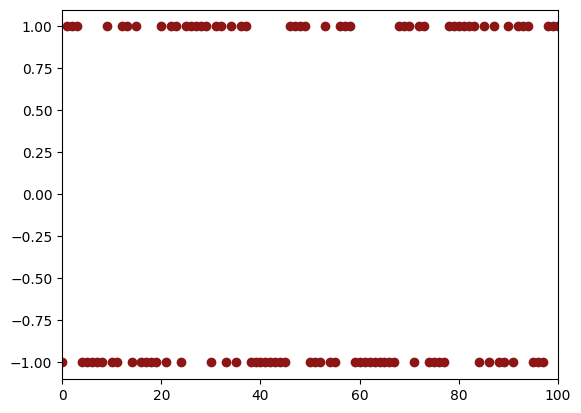

In [ ]:
f_prn = 10.23e6 / 10  # chipping frequency

# find ca code for sat 24, and make 0 into -1 to use in BPSK
sat_24 = np.array( [-1 if x==0 else x for x in PRN(24)] )

sat_12 = np.array( [-1 if x==0 else x for x in PRN(12)] )

sat_07 = np.array( [-1 if x==0 else x for x in PRN(7)] )

shift1 = 18 # the delay... which we can use to figure out the time
shift2 = 190
shift3 = 724

sat_24 = np.roll( np.array( PRN(24), dtype="bool" ), shift1 )
sat_12 = np.roll( np.array( PRN(12), dtype="bool" ), shift2 )
sat_07 = np.roll( np.array( PRN(7), dtype="bool" ), shift3 )

signal = np.logical_xor( sat_24, sat_12 )
signal = np.logical_xor( signal, sat_07 )
signal = 2*signal-1 # convert to -1 and 1

from matplotlib import pyplot as plt
plt.plot(signal, 'o')
plt.xlim( [0,100])
plt.show()


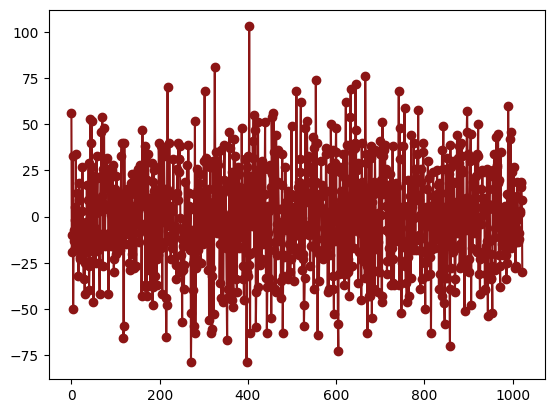

In [ ]:
ref = -1+2*np.array( PRN(12), dtype="bool" )

cross_corr = np.correlate(np.flip(ref), signal, mode='same')
plt.plot(cross_corr)
plt.show()
